# Detecting Anomales in User-Reviews

#### Libraries
- **SQLite3**
- **Matplotlib**:
2D plotting library used to produce figures.
- **Numpy**:
Used for scientific computing; linear algebra, Fourier transform, etc.
- **Pandas**:
Provides data structures and data analysis tools.

#### First Steps
1. Import the libraries mentioned above.
2. Define the fully qualified path name to our database file.
3. Define a conn(ection) variable with a link to the database file.

In [477]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

apps = ['Facebook', 'Instagram', 'Waze', 'Whatsapp', 'Calorie', 'Pinterest', 'Fitbit']

db_path = "/Users/gohost/Projects/anomales/jupyter-notebooks/user-reviews/reviews_with_truthset.db"

conn = sqlite3.connect(db_path)

### Data Exploration: Project on Cultural Bias in User-Reviews

#### Data
1. 68,000 user reviews from Twitter

#### Applications Reviewed
- Facebook
- Instagram
- Waze
- WhatsApp
- Calorie Counter MyFitnessPal
- Pinterest
- Fitbit

#### Structuring
- For each application, collect columns: **app_name**, **date**, and **score**
- Compile all data in a dictionary: `app_dfs = { 'app_name' : app_df }`

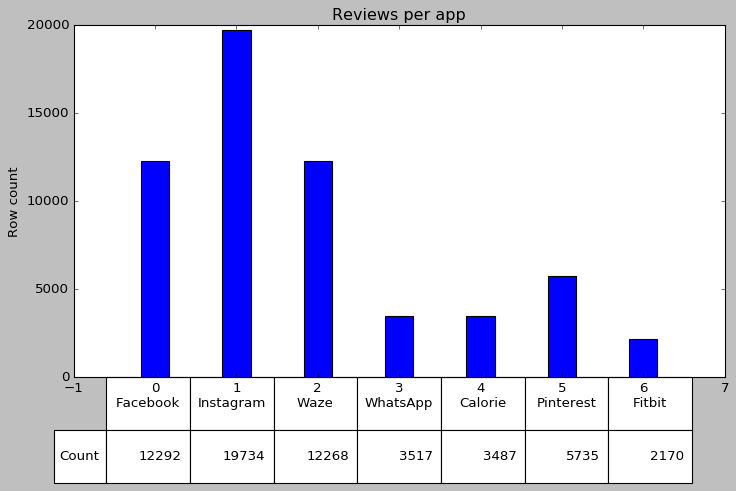

<Figure size 1120x800 with 0 Axes>

In [476]:
# Prepare and execute SQL queries for each app
facebook = pd.read_sql_query('select app_name, date, score '
                       'from reviews '
                        'where app_name = "Facebook"',
                                conn, parse_dates='date')
instagram = pd.read_sql_query('select app_name, date, score '
                         'from reviews '
                         'where app_name = "Instagram"',
                                 conn, parse_dates='date')
waze = pd.read_sql_query('select app_name, date, score '
                         'from reviews '
                         'where app_name = "Waze"',
                                 conn, parse_dates='date')
whatsapp = pd.read_sql_query('select app_name, date, score '
                         'from reviews '
                         'where app_name = "Whatsapp"',
                                 conn, parse_dates='date')
calorie = pd.read_sql_query('select app_name, date, score '
                         'from reviews '
                         'where app_name = "Calorie Counter MyFitnessPal"',
                                 conn, parse_dates='date')
pinterest = pd.read_sql_query('select app_name, date, score '
                         'from reviews '
                         'where app_name = "Pinterest"',
                                 conn, parse_dates='date')
fitbit = pd.read_sql_query('select app_name, date, score '
                         'from reviews '
                         'where app_name = "Fitbit"',
                                 conn, parse_dates='date')

# Count number of rows per app
facebook_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Facebook"', conn)
instagram_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Instagram"', conn)
waze_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Waze"', conn)
whatsapp_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Whatsapp"', conn)
calorie_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Calorie Counter MyFitnessPal"', conn)
pinterest_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Pinterest"', conn)
fitbit_rows = pd.read_sql_query('SELECT COUNT(*) FROM reviews '
                                  'WHERE app_name = "Fitbit"', conn)

# Create (Pandas) DataFrame's for each app
facebook_df = pd.DataFrame(facebook,
                           columns=['app_name', 'date', 'score'])
instagram_df = pd.DataFrame(instagram,
                           columns=['app_name', 'date', 'score'])
waze_df = pd.DataFrame(waze,
                           columns=['app_name', 'date', 'score'])
whatsapp_df = pd.DataFrame(whatsapp,
                           columns=['app_name', 'date', 'score'])
calorie_df = pd.DataFrame(calorie,
                           columns=['app_name', 'date', 'score'])
pinterest_df = pd.DataFrame(pinterest,
                           columns=['app_name', 'date', 'score'])
fitbit_df = pd.DataFrame(fitbit,
                           columns=['app_name', 'date', 'score'])

# Make list of all DataFrames
app_dfs = [facebook_df,
           instagram_df,
           waze_df,
           whatsapp_df,
           calorie_df,
           pinterest_df,
           fitbit_df]

# Make a dictionary (key, value)
app_df_dict = {
    'facebook' : facebook_df,
    'instagram' : instagram_df,
    'waze' : waze_df,
    'whatsapp' : whatsapp_df,
    'calorie' : calorie_df,
    'pinterest' : pinterest_df,
    'fitbit' : fitbit_df
}

# Make a table displaying the number of rows for each app
columns = ('Facebook', 'Instagram', 'Waze', 'WhatsApp', 'Calorie', 'Pinterest', 'Fitbit')

row_counts = [facebook_rows.iloc[0]['COUNT(*)'],
              instagram_rows.iloc[0]['COUNT(*)'],
              waze_rows.iloc[0]['COUNT(*)'],
              whatsapp_rows.iloc[0]['COUNT(*)'],
              calorie_rows.iloc[0]['COUNT(*)'],
              pinterest_rows.iloc[0]['COUNT(*)'],
              fitbit_rows.iloc[0]['COUNT(*)']]

fig, ax = plt.subplots()
fig.set_size_inches(10.5, 5.5)

rowcount_table = plt.table(cellText=[row_counts],
                           rowLabels=['Count'],
                           colLabels=columns,
                           loc='bottom',
                           bbox=[0.05, -0.3, 0.9, 0.3])

rowcount_bar = plt.bar(np.arange(7),
                       row_counts,
                       0.35)
plt.ylabel('Row count')
plt.title('Reviews per app')


fig=plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='w')

rowcount_table.set_fontsize(18)

plt.show()

# Preparing Time Series
## Adding Columns to the Data Set: Year, Month, Weekday Name
Pandas data structures for working with dates and times.
- A single point in time is represented as a _Timestamp_
- _DatetimeIndex_ is the core data structure that powers Pandas time series functionality

In [353]:
# The specific formatting of our 'date' column in table 'reviews'
form = '%Y-%m-%d %H:%M:%S'
app_ts = []
app_ts_dict = {}

# Iterate over all DataFrames and add columns year, month, weekday
for df in app_dfs:
    df['date'] = pd.to_datetime(df['date'], format=form)
    df = df.set_index(pd.DatetimeIndex(df['date']))
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Weekday Name'] = df.index.weekday_name
    app_ts.append(df)
    app_ts_dict[df['app_name'][0]] = df;
    
# Display sample
app_ts[5].sample(5, random_state=0)
app_ts[5].index

DatetimeIndex(['2017-06-30', '2017-06-30', '2017-06-30', '2017-06-30',
               '2017-06-30', '2017-06-30', '2017-06-30', '2017-06-29',
               '2017-06-29', '2017-06-29',
               ...
               '2017-05-20', '2017-05-14', '2017-05-08', '2017-05-07',
               '2017-05-06', '2017-05-05', '2017-05-04', '2017-05-04',
               '2017-05-04', '2017-05-02'],
              dtype='datetime64[ns]', name='date', length=5735, freq=None)

# Visualizing Time Series
Here we want to make visualizations of our data, indexed by time, and want to show:
1. Average score per day _line plot_
2. Average amount of 'reviews per day

## Average score per day
1. Select a slice of time with `dataframe.loc['2017-01-20':'2017-05-20]`
2. Per day, sum all scores and divide by number of rows

First we evaluate the earliest and latest dates of the reviews, in order to select a suitable time slice.

### Printing out the earliest, and latest dates of a review per app.
	Facebook
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

	Instagram
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

	Waze
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

	Whatsapp
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

	Calorie Counter Myfitnesspal
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

	Pinterest
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

	Fitbit
	First: 2017-05-01 00:00:00 Latest: 2017-06-30 00:00:00

### Collecting all row entries per app in the month of May 2017.
	Facebook has 5937 entries in this slice.

	Instagram has 9405 entries in this slice.

	Waze has 7076 entries in this slice.

	Whatsapp has 1846 entries in this slice.

	Calorie Counter MyFitnessPal has 1836 entries in this slice.

	Pinterest has 2217 entries in this slice.

	Fitbit has 1179 entries in this slice.



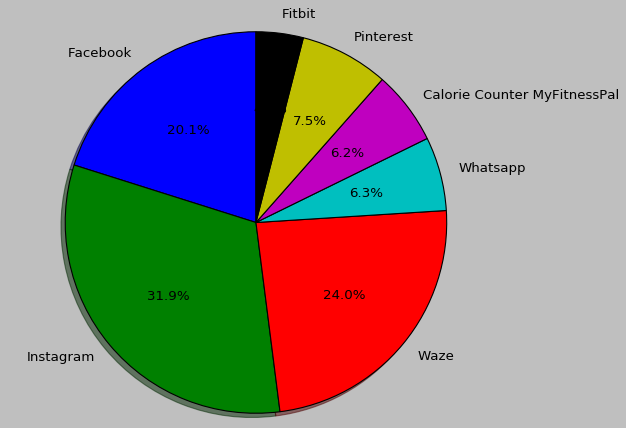

<Figure size 1120x800 with 0 Axes>

In [475]:
import tabulate

min_max_table = [['Facebook'],
                 ['Instagram'],
                 ['Waze'],
                 ['WhatsApp'],
                 ['Calorie'],
                 ['Pinterest'],
                 ['Fitbit']]
                 
app_min_max = {
    'Facebook' : (0,0)
}              
for app, df in app_ts_dict.items():
    app_min_max[app] = (df.index.min(), df.index.max())

print("### Printing out the earliest, and latest dates of a review per app.")
for app, min_max in app_min_max.items():
    print(f"\t{app.title()}")
    print(f"\tFirst: {min_max[0]} Latest: {min_max[1]}\n")
    
# Select 'slice' (... the month of May 2017)
app_ts_slices = {}
print("### Collecting all row entries per app in the month of May 2017.")
for app, df in app_ts_dict.items():
    app_ts_slices[app] = df.loc['2017-05-01':'2017-05-30']
    print(f"\t{app} has {len(app_ts_slices[app].index)} entries in this slice.\n")
    
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
for name, df in app_ts_slices.items():
    labels.append(name)
    sizes.append(len(df.index))
    
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig=plt.figure(figsize=(14, 10), dpi= 80, facecolor='w', edgecolor='w')


plt.show()

# Getting Averages Values
Now we have collected rows from the table per app in the timeframe May 2017.

The variable `app_ts_slices` is a dictionary holding the desired timeframes, accessible by using the _app name_ as key.

We now proceed to:
- Iterate through each date index and sum all score rows belonging to that day -- per app --putting the average in a new list.
- Once we have lists with the average scores -- per app -- for every day of the time slice, we plot them together in a **line plot**.


In [423]:
print(app_ts_slices.keys())

date_range = pd.date_range("2017-05-01", "2017-05-30", freq="D")
cols = app_ts_slices.keys()

scores = {
    'Facebook': []
}
for app, df in app_ts_slices.items(): # go through each app name
    scores[app] = [] # prepare a new entry in dictionary for the app
    for single_date in date_range: # go through every date
        app_scores = pd.read_sql_query('SELECT score ' # collect all scores on that date
                             'FROM reviews '
                             'WHERE date = (?) '
                             'AND app_name = (?)',
                              conn,
                            params=(single_date.strftime(form), # param1: the date
                                   app)) # param2: app name
        
        num_rows = len(app_scores.index) # count the number of rows
        score_sum_on_date = app_scores.sum(axis=0) # sum the rows
        avg_score_on_date = (score_sum_on_date/num_rows) # sum / num = avg
        scores[app].append(avg_score_on_date['score']) # { 'Facebook' : [list of avg scores] }

scores_df = pd.DataFrame(scores, columns=cols) # make new dataframe
scores_df['date'] = pd.to_datetime(date_range, format="%Y-%M-%D") # make DatetimeIndex
scores_df = scores_df.set_index(pd.DatetimeIndex(scores_df['date'])) # set index to DatetimeIndex

scores_df = scores_df.rename(columns={'Calorie Counter MyFitnessPal': 'Calorie'}) # rename difficult column

scores_df.head(5)

dict_keys(['Facebook', 'Instagram', 'Waze', 'Whatsapp', 'Calorie Counter MyFitnessPal', 'Pinterest', 'Fitbit'])


,Facebook,Instagram,Waze,Whatsapp,Calorie,Pinterest,Fitbit,date
date,,,,,,,,
2017-05-01,1.582677,3.092715,4.419048,3.363636,4.587302,3.762500,3.540541,2017-05-01
2017-05-02,1.481481,3.116838,4.346154,3.215190,4.478261,3.228070,3.148148,2017-05-02
2017-05-03,1.440678,3.367521,4.473684,2.253623,4.765625,4.023529,3.658537,2017-05-03
2017-05-04,2.549763,3.177083,4.074074,3.240000,4.714286,3.693333,3.531915,2017-05-04
2017-05-05,2.498221,3.516014,3.975309,3.483516,4.536585,4.015385,3.680851,2017-05-05


# Plotting Average Values
Building on the data processing we did in the previous step, we are now ready to plot the average values for score -- per day, per app -- in a line chart.

## Average score per day

1. Use _scores_df['date']_ as our X-axis
2. Use _scores_df['app_name']_ as our Y-axis (all the scores per app)

Text(0.5, 1.0, 'Average scores per day')

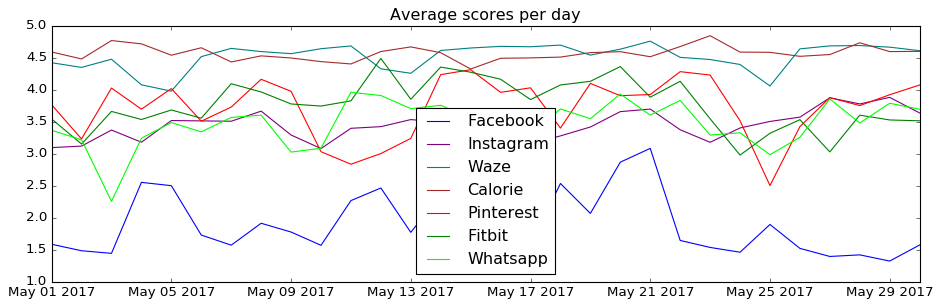

In [422]:
plt.style.use('classic')
fig=plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(scores_df['date'], scores_df['Facebook'], label='Facebook',
         color='blue', linestyle='solid', linewidth=1)

plt.plot(scores_df['date'], scores_df['Instagram'], label='Instagram',
         color='purple', linestyle='solid', linewidth=1)

plt.plot(scores_df['date'], scores_df['Waze'], label='Waze',
         color='teal', linestyle='solid', linewidth=1)

plt.plot(scores_df['date'], scores_df['Calorie'], label='Calorie',
         color='brown', linestyle='solid', linewidth=1)

plt.plot(scores_df['date'], scores_df['Pinterest'], label='Pinterest',
         color='red', linestyle='solid', linewidth=1)

plt.plot(scores_df['date'], scores_df['Fitbit'], label='Fitbit',
         color='green', linestyle='solid', linewidth=1)

plt.plot(scores_df['date'], scores_df['Whatsapp'], label='Whatsapp',
         color='lime', linestyle='solid', linewidth=1)

plt.legend(loc='best')
plt.title("Average scores per day")

## Average amount of reviews per day

In [424]:
print(f"Apps: {app_ts_slices.keys()}\n")
print(f"Date range: {date_range}\n")

# Prepare dictionary to hold average number of reviews per day
app_reviews = {
    "Facebook" : []
}

for app, df in app_ts_slices.items(): # go through each app name
    app_reviews[app] = [] # prepare a new entry in dictionary for the app
    for single_date in date_range: # go through every date
        app_scores = pd.read_sql_query('SELECT score ' # collect all scores on that date
                             'FROM reviews '
                             'WHERE date = (?) '
                             'AND app_name = (?)',
                              conn,
                            params=(single_date.strftime(form), # param1: the date
                                   app)) # param2: app name
        
        review_count = len(app_scores.index) # count the number of reviews
        app_reviews[app].append(review_count) # { 'Facebook' : [list of review counts] }

reviews_df = pd.DataFrame(app_reviews, columns=app_ts_slices.keys()) # make new dataframe
reviews_df['date'] = pd.to_datetime(date_range, format="%Y-%M-%D") # make DatetimeIndex
reviews_df = reviews_df.set_index(pd.DatetimeIndex(scores_df['date'])) # set index to DatetimeIndex

reviews_df = reviews_df.rename(columns={'Calorie Counter MyFitnessPal': 'Calorie'}) # rename difficult column

reviews_df.head(5)

Apps: dict_keys(['Facebook', 'Instagram', 'Waze', 'Whatsapp', 'Calorie Counter MyFitnessPal', 'Pinterest', 'Fitbit'])

Date range: DatetimeIndex(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30'],
              dtype='datetime64[ns]', freq='D')



,Facebook,Instagram,Waze,Whatsapp,Calorie,Pinterest,Fitbit,date
date,,,,,,,,
2017-05-01,127,453,105,99,63,80,37,2017-05-01
2017-05-02,108,291,78,79,69,57,27,2017-05-02
2017-05-03,177,234,76,276,64,85,41,2017-05-03
2017-05-04,211,288,81,125,49,75,47,2017-05-04
2017-05-05,281,281,81,91,41,65,47,2017-05-05


Text(0.5, 1.0, 'Average number of reviews per day')

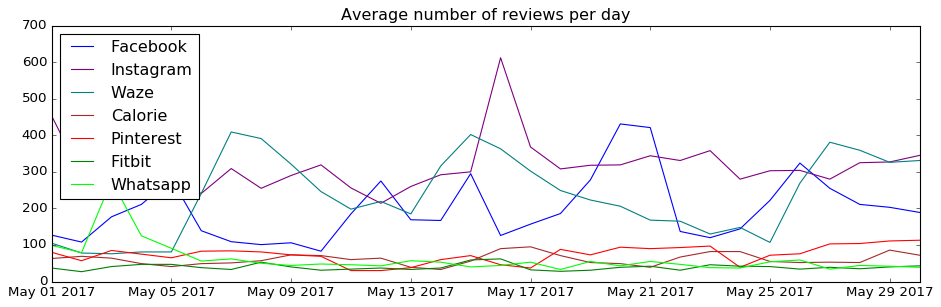

In [426]:
plt.style.use('classic')
fig=plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(reviews_df['date'], reviews_df['Facebook'], label='Facebook',
         color='blue', linestyle='solid', linewidth=1)

plt.plot(reviews_df['date'], reviews_df['Instagram'], label='Instagram',
         color='purple', linestyle='solid', linewidth=1)

plt.plot(reviews_df['date'], reviews_df['Waze'], label='Waze',
         color='teal', linestyle='solid', linewidth=1)

plt.plot(reviews_df['date'], reviews_df['Calorie'], label='Calorie',
         color='brown', linestyle='solid', linewidth=1)

plt.plot(reviews_df['date'], reviews_df['Pinterest'], label='Pinterest',
         color='red', linestyle='solid', linewidth=1)

plt.plot(reviews_df['date'], reviews_df['Fitbit'], label='Fitbit',
         color='green', linestyle='solid', linewidth=1)

plt.plot(reviews_df['date'], reviews_df['Whatsapp'], label='Whatsapp',
         color='lime', linestyle='solid', linewidth=1)

plt.legend(loc='best')
plt.title("Average number of reviews per day")

# Boxplots of Average Score

<Figure size 1120x320 with 0 Axes>

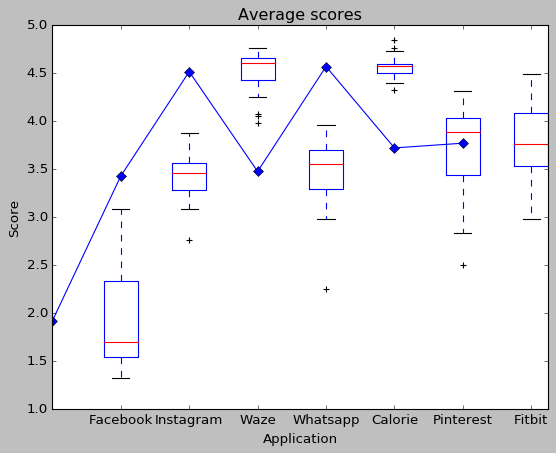

In [466]:
def boxplot(title, xname, yname, data, xlabels, means):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.boxplot(data, labels=xlabels)
    ax.plot(xlabels, means, marker='D')
    ax.set_ylabel(yname)
    ax.set_xlabel(xname)
    plt.show()
    
ll = []
for app_name in app_ts_slices.keys():
    ll.append(scores[app_name])

means = []
for x in ll:
    total = sum(x)
    mean = total/len(x)
    means.append(mean)
    
xlab = scores_df.columns.values.tolist()
xlab.remove('date')

boxplot("Average scores", "Application", "Score", ll, xlab, means)